In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras.models import load_model

# Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])

# Filtrar los datos para obtener el clúster 1 y la localidad "TOPOLOBAMPO"
cluster_1_topolobampo = data[(data['Cluster_Label'] == 1) & (data['NOM_LOC'] == 'TOPOLOBAMPO')]

# Filtrar los datos para el año 2023
test_data_2023 = cluster_1_topolobampo[cluster_1_topolobampo['year'] == 2023]


2024-06-27 19:51:25.472709: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 19:51:26.697857: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-27 19:51:29.089932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 19:51:29.090033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 19:51:29.341961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Función para preparar los datos de prueba
def prepare_test_data(group, look_back=3):
    features = ['landed_w_kg', 'Cluster_Label', '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m',
                '5.0782242_m', '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
    scaler = MinMaxScaler(feature_range=(0, 1))
    group_scaled = scaler.fit_transform(group[features])
    
    X = []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    return X, scaler

# Función para comparar los valores pronosticados con los reales y calcular MSE y R2
def evaluate_predictions(real, predicted):
    mse = mean_squared_error(real, predicted)
    r2 = r2_score(real, predicted)
    return mse, r2

# Función para crear figuras de las series de tiempo
def plot_series(real, predicted, species_name):
    plt.figure(figsize=(10, 6))
    plt.plot(real, color='blue', label='Real')
    plt.plot(predicted, color='red', linestyle='--', label='Predicho')
    plt.title(f'Pronóstico de {species_name} en 2023')
    plt.xlabel('Tiempo')
    plt.ylabel('Peso Desembarcado (kg)')
    plt.legend()
    plt.show()



In [3]:
species_list = ['ALMEJA', 'BANDERA', 'BAQUETA', 'BERRUGATA', 'CABRILLA', 'CALAMAR',
                'CARACOL', 'CAZON', 'CORVINA', 'GUACHINANGO', 'JAIBA', 'JUREL',
                'LENGUADO', 'LISA', 'LOBINA', 'MERO', 'MOJARRA', 'OSTION',
                'PAMPANO', 'PARGO', 'PIERNA', 'PULPO', 'RAYA Y SIMILARES',
                'ROBALO', 'RONCO', 'SARDINA', 'SIERRA', 'TIBURON']

2/2 [==============================] - 1s 4ms/step


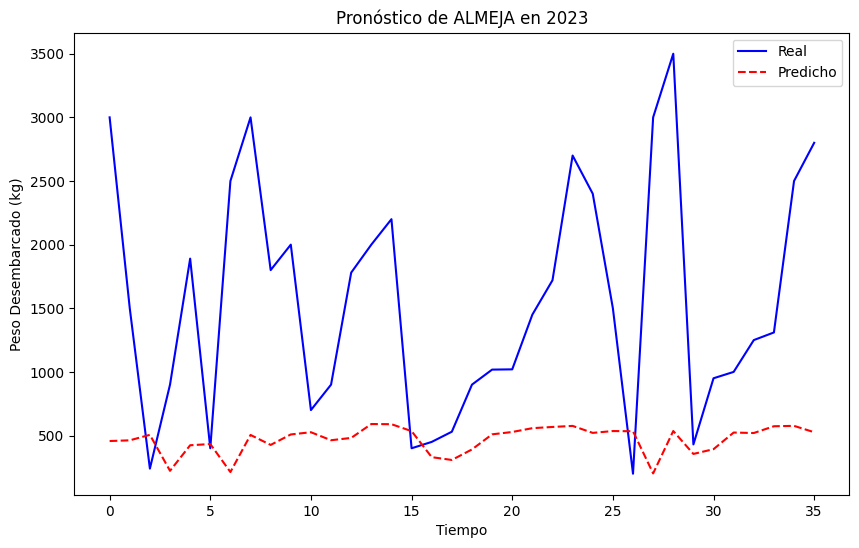

No se tienen datos suficientes para BANDERA
1/1 [==============================] - 1s 578ms/step


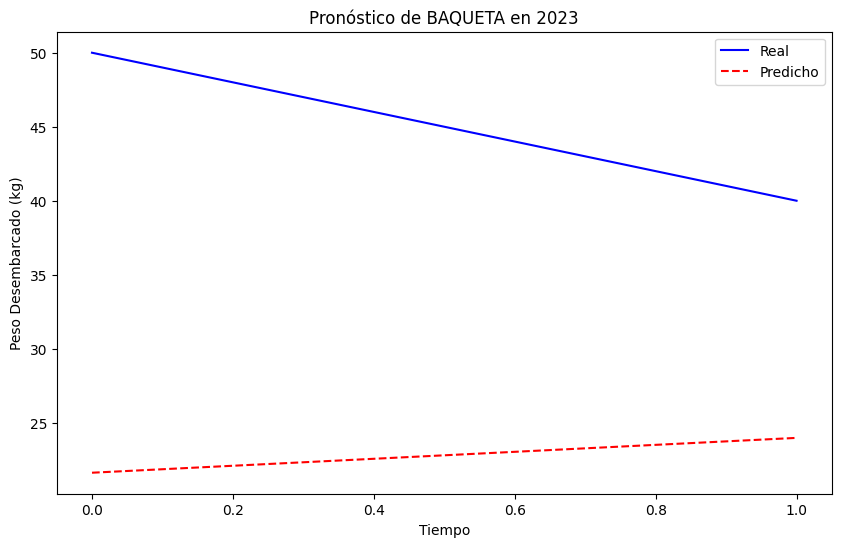

1/1 [==============================] - 1s 581ms/step


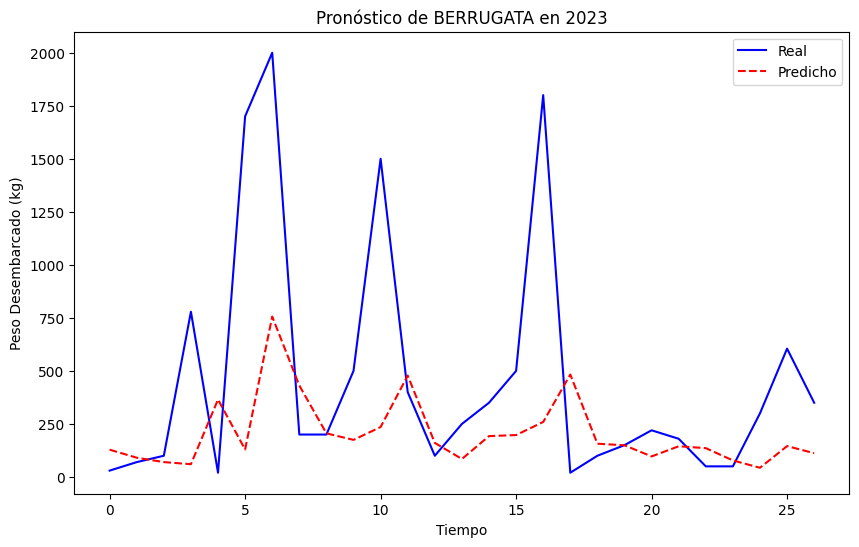

No se tienen datos suficientes para CABRILLA
No se tienen datos suficientes para CALAMAR
No se tienen datos suficientes para CARACOL
1/1 [==============================] - 1s 581ms/step


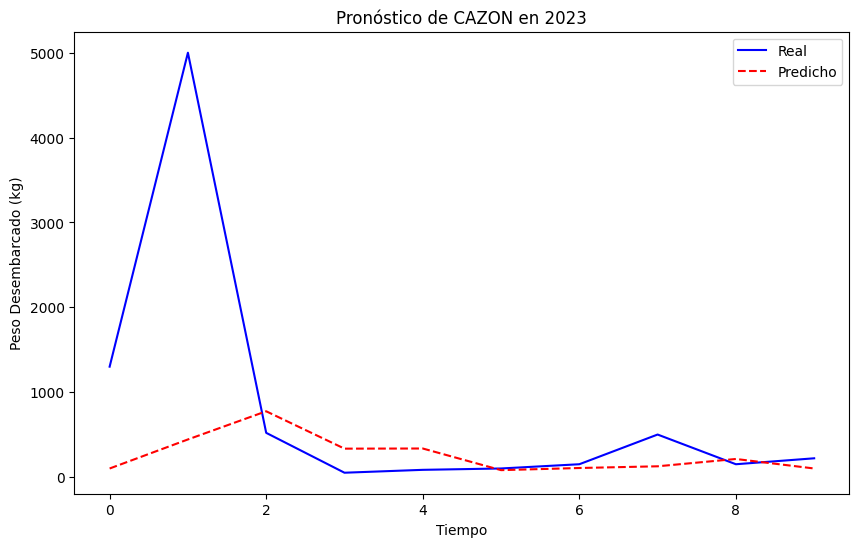

3/3 [==============================] - 1s 4ms/step


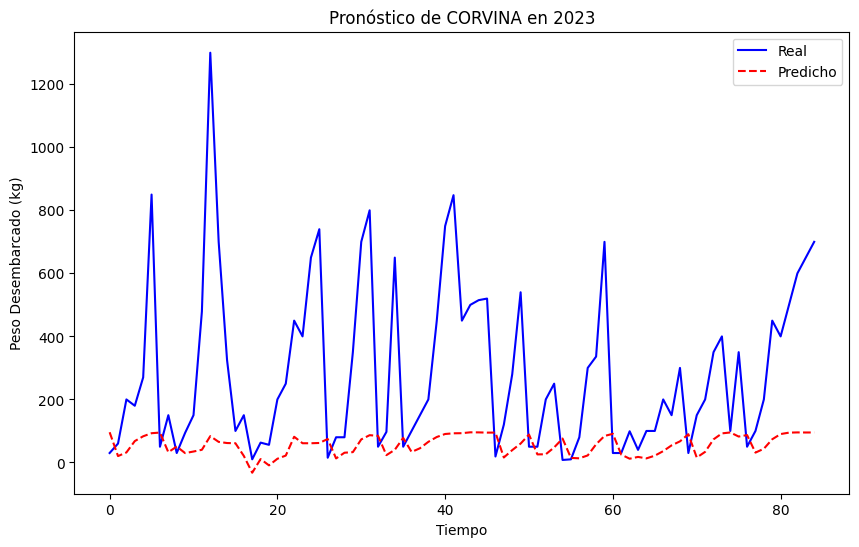

4/4 [==============================] - 1s 3ms/step


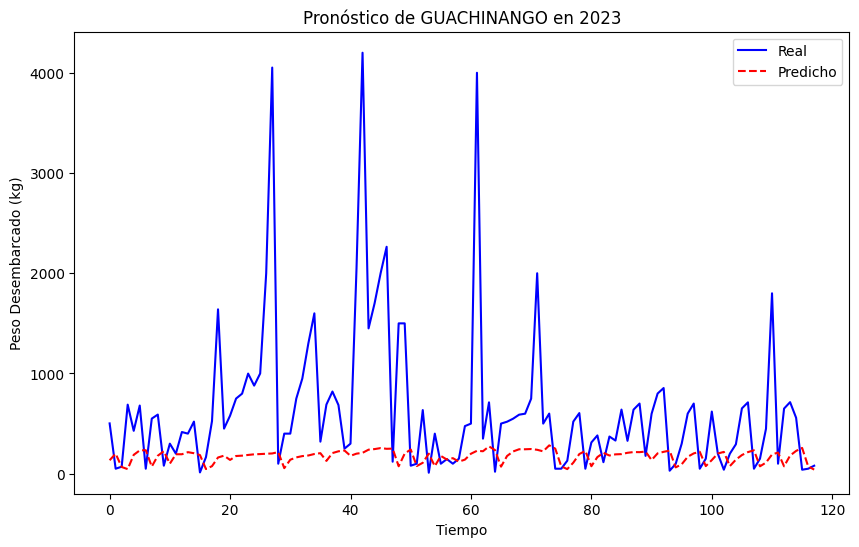

11/11 [==============================] - 1s 3ms/step


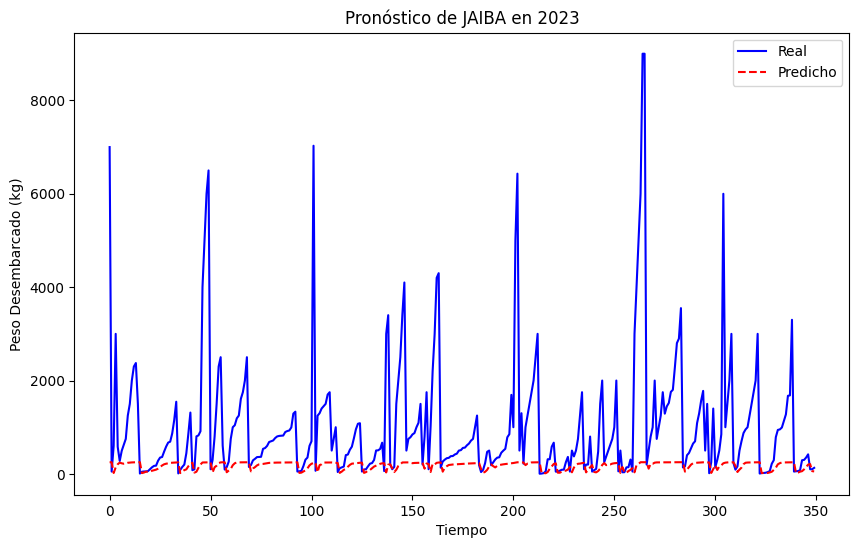

1/1 [==============================] - 1s 625ms/step


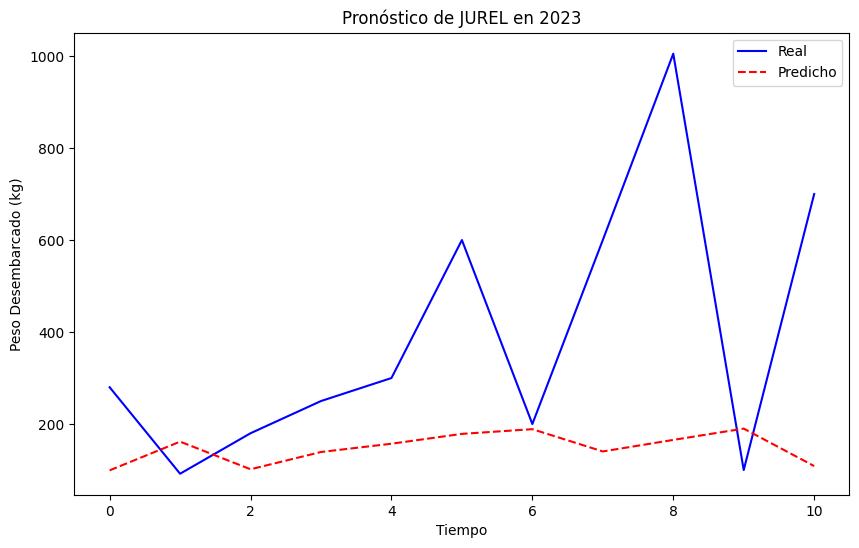

1/1 [==============================] - 1s 565ms/step


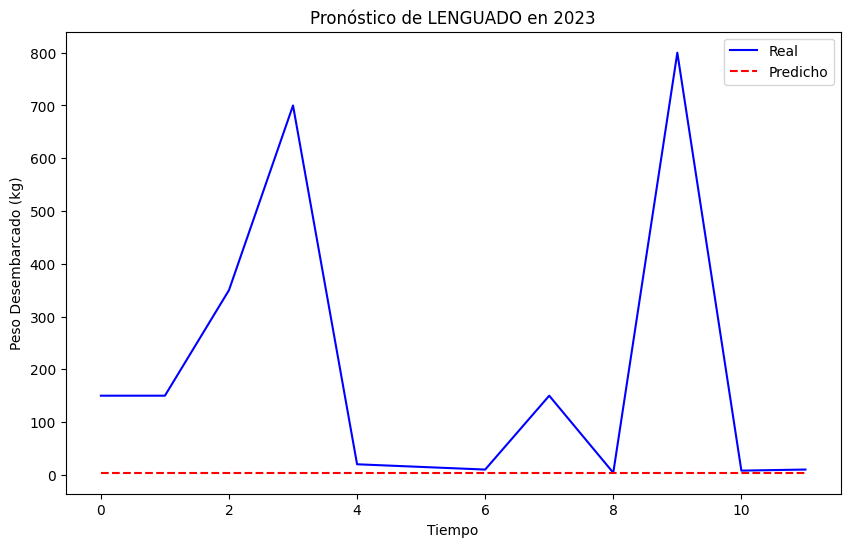

6/6 [==============================] - 1s 3ms/step


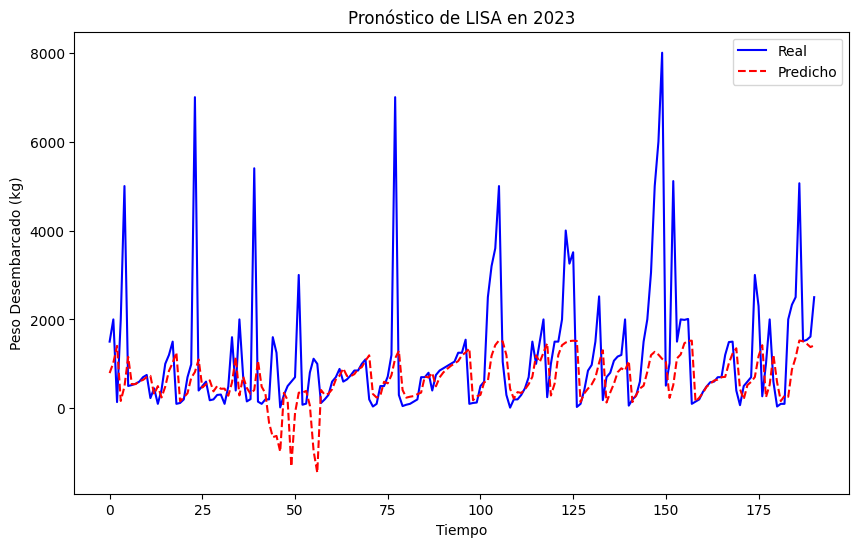

No se tienen datos suficientes para LOBINA
No se tienen datos suficientes para MERO
1/1 [==============================] - 1s 591ms/step


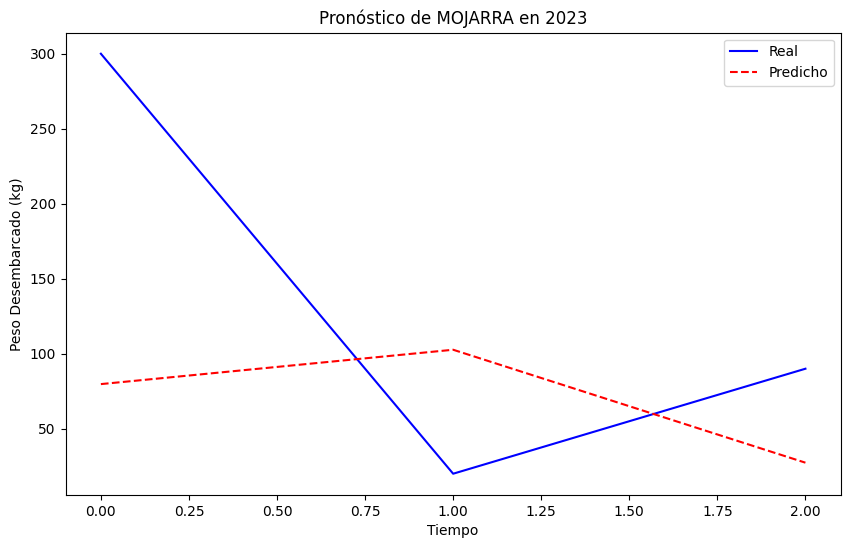

1/1 [==============================] - 1s 582ms/step


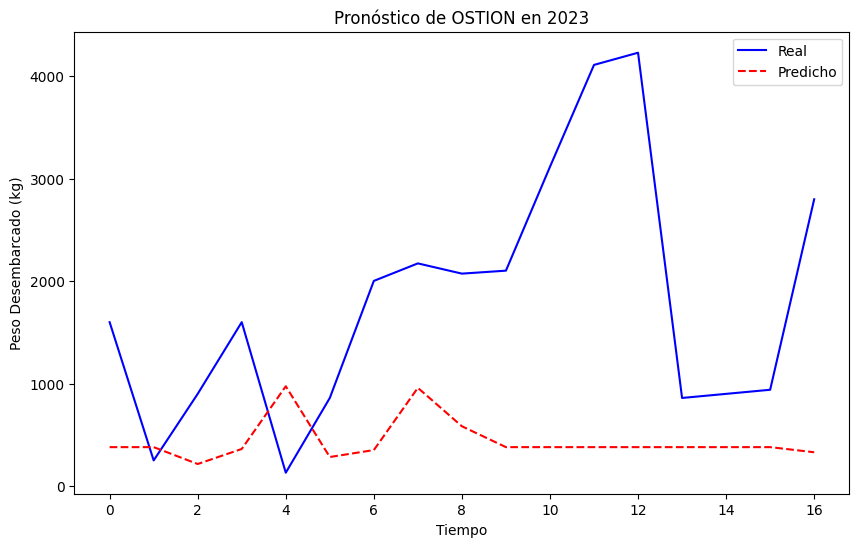

1/1 [==============================] - 1s 547ms/step


/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


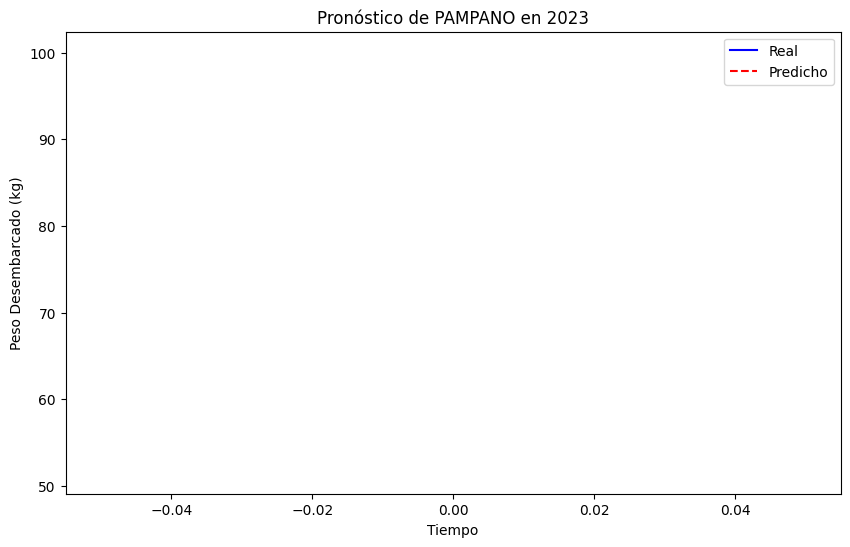

7/7 [==============================] - 1s 3ms/step


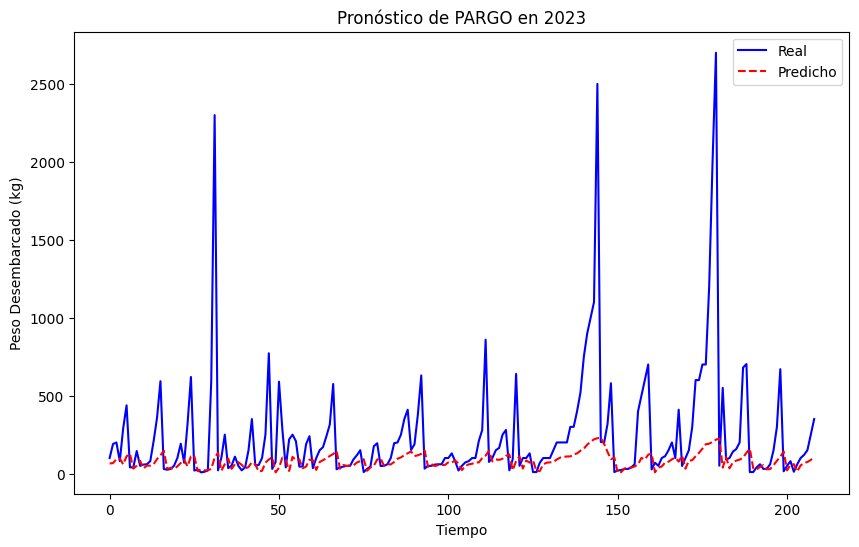

No se tienen datos suficientes para PIERNA
No se tienen datos suficientes para PULPO
No se tienen datos suficientes para RAYA Y SIMILARES
1/1 [==============================] - 1s 578ms/step


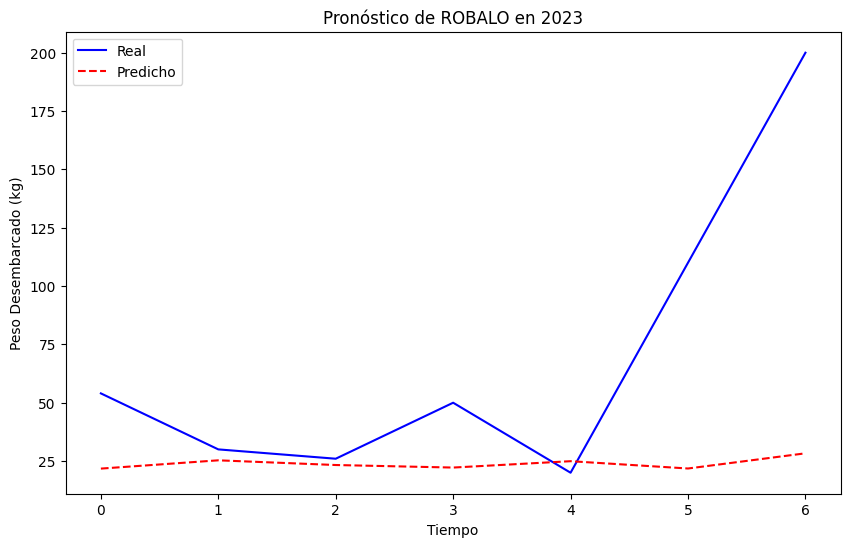

1/1 [==============================] - 1s 936ms/step


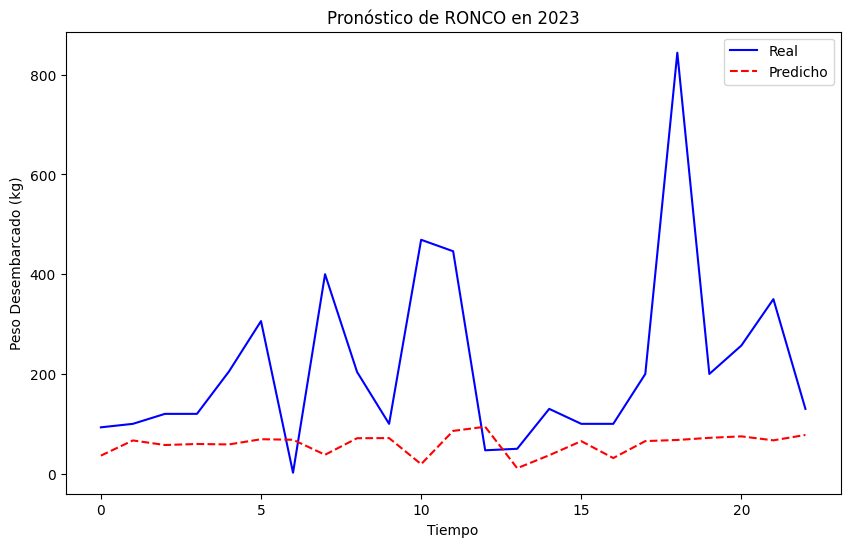

No se tienen datos suficientes para SARDINA
2/2 [==============================] - 1s 4ms/step


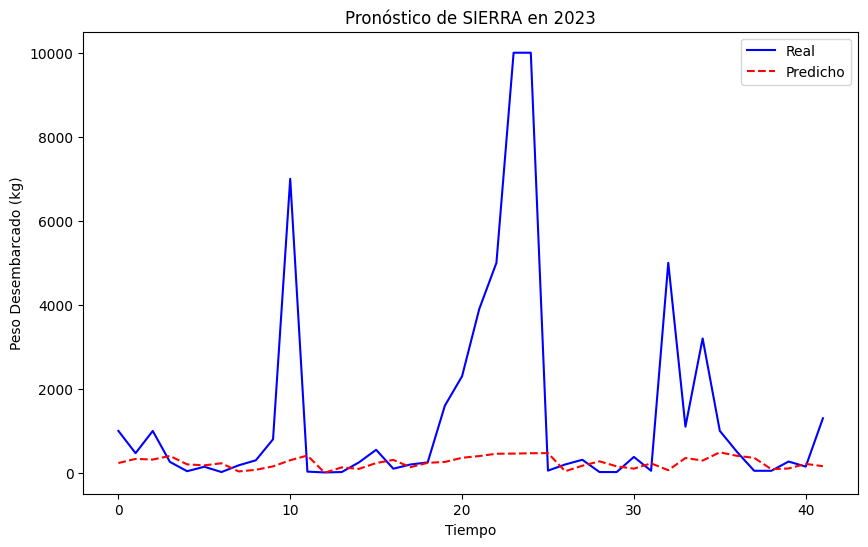

No se tienen datos suficientes para TIBURON


In [4]:
# Diccionario para almacenar los resultados
results = {}

for species in species_list:
    species_data = test_data_2023[test_data_2023['species'] == species]
    
    if len(species_data) < 3:  # Asegurarse de que hay suficientes datos
        print(f'No se tienen datos suficientes para {species}')
        continue
    
    X_test, scaler = prepare_test_data(species_data)
    real_values = species_data['landed_w_kg'].values[3:]
    
    # Predecir usando el modelo guardado
    model_path = f'modelos/{species}_model.h5'
    
    if not os.path.exists(model_path):
        print(f'No se encontró el modelo para {species}')
        continue
    
    model = load_model(model_path)
    predictions_scaled = model.predict(X_test)
    
    # Invertir la escala de los valores pronosticados
    predictions = scaler.inverse_transform(np.hstack((predictions_scaled, X_test[:, -1, 1:])))[:, 0]
    
    mse, r2 = evaluate_predictions(real_values, predictions)
    results[species] = {'MSE': mse, 'R2': r2}
    
    # Crear figura
    plot_series(real_values, predictions, species)



In [5]:

# Mostrar los resultados
for species, metrics in results.items():
    print(f'Especie: {species}, MSE: {metrics["MSE"]}, R2: {metrics["R2"]}')

Especie: ALMEJA, MSE: 1984432.404845831, R2: -1.407213774748326
Especie: BAQUETA, MSE: 530.9089089648587, R2: -20.23635635859435
Especie: BERRUGATA, MSE: 352661.1428150274, R2: -0.07884280524804765
Especie: CAZON, MSE: 2258333.9015127355, R2: -0.0855073877095851
Especie: CORVINA, MSE: 116589.10391836509, R2: -0.6826017748067303
Especie: GUACHINANGO, MSE: 764171.0506717544, R2: -0.3652042334119392
Especie: JAIBA, MSE: 2475710.446224935, R2: -0.3604760011187591
Especie: JUREL, MSE: 138884.06200449157, R2: -0.7859712546395987
Especie: LENGUADO, MSE: 108436.30160663296, R2: -0.5236696803122378
Especie: LISA, MSE: 1959706.6354599886, R2: -0.023667206821605502
Especie: MOJARRA, MSE: 19755.71701529239, R2: -0.39561580170825383
Especie: OSTION, MSE: 3359796.3810105207, R2: -1.4063666642387096
Especie: PAMPANO, MSE: 2349.7876197058376, R2: nan
Especie: PARGO, MSE: 148771.7488799966, R2: -0.06248897487870542
Especie: ROBALO, MSE: 5588.026394004162, R2: -0.5527224816620013
Especie: RONCO, MSE: 58